# Dinamiche post-errore {#sec-post-error}

**Prerequisiti**

- Leggere l'@sec-appendix-markov-first-order.

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [33]:
import os
import itertools
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import bambi as bmb
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
import warnings

warnings.simplefilter(action="ignore")

In [2]:
seed: int = sum(map(ord, "stan_canoeing"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(home_directory, '_repositories', 'psicometria')

## Introduzione

In questo capitolo introdurremo i modelli dinamici utilizzando un semplice processo di Markov di primo livello. Utilizzeremo un esempio specifico per spiegare come questi modelli possano essere applicati per testare teorie psicologiche. In particolare, ci concentreremo su due diverse teorie psicologiche del controllo cognitivo che spiegano la prestazione dopo un errore. Le teorie del controllo cognitivo e della performance post-errore rappresentano un'area di ricerca importante e dibattuta nella psicologia cognitiva e nelle neuroscienze cognitive. Le principali correnti teoriche proposte — le teorie funzionali e non funzionali — offrono interpretazioni contrastanti su come gli individui rispondono agli errori in compiti cognitivi.

Le teorie funzionali, come quella proposta da @botvinick2001conflict, si basano sul concetto di "monitoraggio del conflitto". Secondo questo modello, quando si verifica un errore, il sistema cognitivo rileva un conflitto tra la risposta data e quella corretta, innescando un aumento del controllo cognitivo che migliora la performance nelle prove successive. L'area cingolata anteriore (ACC) è considerata cruciale in questo processo, fungendo da "rilevatore di conflitto" e segnalando la necessità di un maggiore controllo cognitivo, mediato dalla corteccia prefrontale dorsolaterale (DLPFC). Studi successivi, come quello di Kerns et al. (2004) utilizzando la risonanza magnetica funzionale (fMRI), hanno supportato questa teoria mostrando che l'attività nell'ACC durante una prova con errore predice un aumento dell'attività nella DLPFC e un miglioramento della performance nella prova successiva.

Al contrario, le teorie non funzionali, come quelle proposte da @notebaert2009post, suggeriscono che la performance post-errore sia peggiore rispetto a quella post-corretta. Queste teorie si basano sul concetto di "orientamento attenzionale" o "disturbo" del sistema cognitivo. Secondo la teoria dell'"orientamento post-errore", gli errori, essendo eventi infrequenti e salienti, catturano l'attenzione del soggetto, distogliendola dal compito in corso, e portano a un rallentamento e peggioramento della performance nelle prove successive.

È importante notare che entrambe le teorie hanno trovato supporto empirico in diversi studi. Ad esempio, Dutilh et al. (2012) hanno trovato evidenze sia di rallentamento post-errore (coerente con le teorie non funzionali) sia di aumento dell'accuratezza post-errore (coerente con le teorie funzionali). @danielmeier2011post hanno proposto una sintesi di questi punti di vista, suggerendo che la risposta agli errori potrebbe coinvolgere più meccanismi operanti su scale temporali diverse: un rallentamento immediato dovuto a un orientamento attenzionale, seguito da un miglioramento della performance dovuto all'aumento del controllo cognitivo.

La maggior parte di questi studi si è basata su compiti di laboratorio altamente controllati, utilizzando paradigmi di scelta forzata a due alternative (2AFC) ripetuti molte volte. Mentre questi paradigmi offrono un alto grado di controllo sperimentale, possono mancare di validità ecologica e non riflettere accuratamente il comportamento in situazioni reali, dove gli errori hanno conseguenze significative.

In questo tutorial, esamineremo il comportamento post-errore e post-prova corretta in situazioni reali, analizzando la performance di atleti durante competizioni di canoa slalom a livello mondiale ed europeo. Utilizzeremo i video degli atleti che attraversano correttamente la linea tra i pali, codificati da due giudici indipendenti, per analizzare la probabilità di commettere un errore dopo un attraversamento corretto o errato di una porta.

Studiando il comportamento in contesti reali, possiamo testare queste previsioni opposte in condizioni in cui gli errori hanno conseguenze significative per l'individuo. Questo approccio offre diversi vantaggi che sono elencati di seguito. 

Studiando il comportamento in una situazione reale di competizione, possiamo osservare come le teorie del controllo cognitivo si applicano in contesti ad alta posta in gioco. Gli atleti di alto livello sono intrinsecamente motivati a performare al meglio, il che potrebbe portare a risposte agli errori più intense e rilevanti rispetto a quelle osservate in laboratorio. Gli atleti di élite hanno una vasta esperienza nel loro sport, che può influenzare i loro meccanismi di controllo cognitivo in modi interessanti e diversi dai partecipanti tipici degli studi di laboratorio. Il canoa slalom richiede l'integrazione di abilità motorie complesse con processi decisionali rapidi, offrendo una visione più completa del controllo cognitivo rispetto ai tipici compiti di laboratorio. I risultati potrebbero avere implicazioni dirette per l'allenamento e la preparazione degli atleti, aumentando la rilevanza pratica della ricerca.

I risultati di questo studio potrebbero fornire importanti indicazioni per le teorie del controllo cognitivo:

- Se si osserva un miglioramento della performance post-errore, questo supporterebbe le teorie funzionali, suggerendo che i meccanismi di controllo cognitivo proposti da @botvinick2001conflict si applicano anche in contesti reali ad alta posta in gioco.
- Se si rileva un peggioramento della performance post-errore, ciò potrebbe supportare le teorie non funzionali e indicare che l'orientamento attenzionale verso gli errori è particolarmente pronunciato in situazioni di competizione reale.
- Potrebbe emergere un pattern più complesso, come un peggioramento iniziale seguito da un miglioramento, che supporterebbe modelli integrativi come quello proposto da @danielmeier2011post.

In conclusione, studiare il controllo cognitivo e la performance post-errore in un contesto sportivo di alto livello offre un'opportunità unica per testare e ampliare le teorie esistenti in un ambiente ecologicamente valido. I risultati possono non solo contribuire alla comprensione teorica del controllo cognitivo, ma anche fornire indicazioni pratiche per migliorare le prestazioni in contesti ad alta posta in gioco.

Iniziamo ad importare i dati.

In [6]:
data_file = os.path.join(project_directory, "data", "canoeing_data.csv")
canoeing_data = pd.read_csv(data_file)
canoeing_data.head()

,athlete,boat_craft,nation,sex,rank,time,run,city,year,runf,gate,accuracy,NGATES,acc,n_gate,lagged_accuracy,sequence_id
0,AABOEN,K1,NOR,M,78,108.99,1,K1M_worlds,2017,1,G1,1.0,23,1.0,1,NaN,1.0
1,AABOEN,K1,NOR,M,78,108.99,1,K1M_worlds,2017,1,G2,1.0,23,1.0,2,1.0,1.0
2,AABOEN,K1,NOR,M,78,108.99,1,K1M_worlds,2017,1,G3,1.0,23,1.0,3,1.0,1.0
3,AABOEN,K1,NOR,M,78,108.99,1,K1M_worlds,2017,1,G4,1.0,23,1.0,4,1.0,1.0
4,AABOEN,K1,NOR,M,78,108.99,1,K1M_worlds,2017,1,G5,1.0,23,1.0,5,1.0,1.0


Calcoliamo alcune statistiche descrittive.

In [29]:
# Numero totale di prove
num_prove = len(canoeing_data)

# Numero di atleti unici
num_atleti = canoeing_data["athlete"].nunique()

# Numero di competizioni uniche
num_competizioni = canoeing_data["city"].nunique()

# Anni in cui sono stati raccolti i dati
anni_raccolti = canoeing_data["year"].unique()

# Stampa dei risultati
print(f"Numero totale di prove: {num_prove}")
print(f"Numero di atleti: {num_atleti}")
print(f"Numero di competizioni: {num_competizioni}")
print(f"Anno in cui sono stati raccolti i dati: {anni_raccolti}")

Numero totale di prove: 66413
Numero di atleti: 459
Numero di competizioni: 20
Anno in cui sono stati raccolti i dati: [2017]


Creiamo la variabile `is_error`, assegnandole il valore 1 se la prova è un errore e 0 altrimenti. Convertiamo inoltre il tipo di variabile in un numero intero, come richiesto dal codice Stan.

In [8]:
canoeing_data["accuracy"] = canoeing_data["accuracy"].fillna(1).astype(int)
canoeing_data["is_error"] = canoeing_data["accuracy"].apply(
    lambda x: 1 if x == 0 else 0
)

Inseriamo i dati in un dizionario nel formato atteso da Stan.

In [14]:
stan_data = {
    "N": len(canoeing_data["accuracy"]), 
    "y": canoeing_data["is_error"]
}

Compiliamo e stampiamo il codice Stan che assume che i dati seguano una distribuzione di Poisson, considerando che le prove siano indipendenti tra loro.

In [15]:
stan_file = os.path.join(
    project_directory, 'stan', 'canoeing_poisson_model.stan')

poisson_model = CmdStanModel(stan_file=stan_file)
print(poisson_model.code())

data {
  int<lower=0> N; // Number of trials
  array[N] int<lower=0> y; // Number of errors in each trial (could be 0 or 1)
}
parameters {
  real<lower=0> lambda; // Rate parameter for the Poisson distribution
}
model {
  // Weak prior on lambda
  lambda ~ normal(0, 10);
  
  // Likelihood: Poisson distribution
  y ~ poisson(lambda);
}
generated quantities {
  vector[N] log_lik; // Log-likelihood for each observation
  for (n in 1 : N) {
    log_lik[n] = poisson_lpmf(y[n] | lambda);
  }
}



Nella sezione `model`, l'istruzione `lambda ~ normal(0, 10);` definisce un prior per il parametro `lambda`, che è il parametro della distribuzione di Poisson. Viene assunto un priore normale debole con media 0 e deviazione standard 10, che riflette l'ipotesi che `lambda` possa prendere qualsiasi valore positivo con una leggera preferenza per valori vicini a zero.

L'istruzione `y ~ poisson(lambda);` definisce la `likelihood`, ovvero la probabilità di osservare i dati `y` dati i parametri del modello. In questo caso, si assume che i dati seguano una distribuzione di Poisson con parametro `lambda`, che rappresenta la media (e varianza) del numero di errori nelle prove. L'assunzione qui è che ogni prova sia indipendente dalle altre e che il numero di errori in ciascuna prova sia distribuito secondo una Poisson.

Nella sezione `generated quantities`, l'istruzione `vector[N] log_lik;` crea un vettore per memorizzare i valori del log-likelihood per ciascuna delle `N` osservazioni. 
  
L'istruzione `for (n in 1:N) { log_lik[n] = poisson_lpmf(y[n] | lambda); }`, mediante un ciclo `for` calcola la log-verosimiglianza per ogni singola osservazione `y[n]` rispetto alla distribuzione di Poisson con il parametro `lambda`. La funzione `poisson_lpmf` calcola la log-probability mass function (log-PMF) della distribuzione di Poisson per un dato valore `y[n]` e un parametro `lambda`. Il risultato è un vettore `log_lik` che contiene la log-verosimiglianza di ciascuna osservazione. Questo è richiesto per effettuare confronti tra modelli usando la Leave-One-Out Cross-Validation (LOO).

Eseguiamo il campionamento.

In [17]:
fit_poisson = poisson_model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False, 
    show_console=False
)

Esaminiamo le distribuzioni a posteriori.

In [18]:
az.summary(fit_poisson, var_names=["lambda"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,0.09,0.0,0.09,0.09,0.0,0.0,3036.8,3682.58,1.0


Convertiamo l'oggetto creato da cmdstanpy nella classe `InferenceData` richiesta da ArviZ:

In [20]:
fit_poisson_az = az.from_cmdstanpy(posterior=fit_poisson)

Eseguiamo la validazione incrociata Leave-One-Out (LOO-CV) utilizzando ArviZ:

In [21]:
loo_poisson_result = az.loo(fit_poisson_az)
print(loo_poisson_result)

Computed from 8000 posterior samples and 66413 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -20564.93   177.70
p_loo        0.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     66413  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%



Tutti i valori di Pareto $k$ sono molto bassi, indicando che nessuna osservazione ha un'influenza eccessiva sulle stime del modello. Di conseguenza, non vi è alcuna evidenza che la stima dell'ELPD, che in questo caso è pari a -20564.93, possa essere distorta. 

Ora calcoleremo l'ELPD per il modello che assume un processo di Markov di primo ordine. Questo modello considera una dipendenza temporale tra le prove, in cui la probabilità di commettere un errore dipende dal risultato della prova precedente. In particolare, il modello stabilisce che la probabilità di una risposta errata in una prova dipende dal fatto che la risposta precedente sia stata corretta o errata.

Compiliamo e stampiamo il modello `canoeing_markov_model.stan`.

In [22]:
stan_file = os.path.join(project_directory, "stan", "canoeing_markov_model.stan")

markov_model = CmdStanModel(stan_file=stan_file)
print(markov_model.code())

data {
  int<lower=0> N; // Number of trials
  array[N] int<lower=0, upper=1> y; // Sequence of errors (0 = correct, 1 = error)
}
parameters {
  real<lower=0, upper=1> p_error_given_error; // Probability of error given previous error
  real<lower=0, upper=1> p_error_given_correct; // Probability of error given previous correct
  real<lower=0, upper=1> p_initial_error; // Initial probability of error
}
model {
  // Implicit weak priors on parameters
  
  // Likelihood for the first trial
  y[1] ~ bernoulli(p_initial_error);
  
  // Likelihood for the rest of the trials
  for (n in 2 : N) {
    if (y[n - 1] == 1) {
      y[n] ~ bernoulli(p_error_given_error);
    } else {
      y[n] ~ bernoulli(p_error_given_correct);
    }
  }
}
generated quantities {
  vector[N] log_lik; // Log-likelihood for each observation
  log_lik[1] = bernoulli_lpmf(y[1] | p_initial_error);
  for (n in 2 : N) {
    if (y[n - 1] == 1) {
      log_lik[n] = bernoulli_lpmf(y[n] | p_error_given_error);
    } else {
  

Questo codice Stan modella una sequenza di prove in cui ogni prova può essere corretta (`0`) o errata (`1`). Questo modello assume una *dipendenza temporale* tra le prove, basata su un *processo di Markov di primo ordine*. Ciò significa che la probabilità di errore in una prova dipende solo dal risultato della prova precedente.

Nella sezione `model`, i parametri `p_error_given_error`, `p_error_given_correct` e `p_initial_error` hanno priors impliciti deboli poiché sono definiti con limiti tra 0 e 1. Non sono stati specificati priors espliciti, quindi Stan utilizzerà prior uniformi su questi parametri.

Il primo elemento della sequenza `y[1]` rappresenta la prima prova. Qui, viene modellata la probabilità che questa prova sia un errore utilizzando una distribuzione di Bernoulli con probabilità `p_initial_error`.

Per tutte le prove successive (dal secondo elemento in poi), il modello assume che la probabilità di errore (`y[n] = 1`) dipenda dal risultato della prova precedente:

  - Se la prova precedente (`y[n-1]`) è stata un errore (`1`), allora la probabilità di errore nella prova attuale è `p_error_given_error`.
  - Se la prova precedente è stata corretta (`0`), allora la probabilità di errore nella prova attuale è `p_error_given_correct`.

  Questo riflette l'idea che l'esito di una prova sia condizionato dallo stato immediatamente precedente, tipico di un processo di Markov di primo ordine.

La sezione `generated quantities` viene utilizzata per calcolare quantità derivate dai parametri stimati, in questo caso, il **log-likelihood** per ogni osservazione.

- *Primo Log-Likelihood*: Per la prima prova (`y[1]`), il log-likelihood è calcolato usando `p_initial_error`, poiché questa prova non ha una dipendenza da prove precedenti.

- *Log-Likelihood delle Prove Successive*: Per tutte le prove successive, il log-likelihood è calcolato in base all'esito della prova precedente, utilizzando `p_error_given_error` o `p_error_given_correct` a seconda che la prova precedente sia stata un errore o un successo. Il calcolo del log-likelihood utilizza la funzione `bernoulli_lpmf`, che restituisce il logaritmo della probabilità della funzione di massa della distribuzione Bernoulli per i dati osservati.

I valori del log-likelihood sono memorizzati nel vettore `log_lik` che verrà usato per valutare il modello attraverso la validazione incrociata LOO. 

In sintesi, il modello rappresenta un processo di Markov di primo ordine in cui l'esito di una prova dipende dall'esito della prova precedente. La sezione `generated quantities` calcola il log-likelihood per ciascuna osservazione, consentendo di valutare e confrontare il modello utilizzando la tecnica bayesiana della validazione incrociata LOO.

Eseguiamo il campionamento.

In [23]:
fit_markov = markov_model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

Esaminiamo le stime a posteriori dei parametri del modello.

In [30]:
az.summary(
    fit_markov, var_names=["p_error_given_error", "p_error_given_correct"], round_to=2
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_error_given_error,0.18,0.0,0.17,0.19,0.0,0.0,7522.48,5864.69,1.0
p_error_given_correct,0.08,0.0,0.08,0.08,0.0,0.0,7353.13,5562.07,1.0


Calcoliamo l'ELPD con il metodo LOO-CV.

In [25]:
# Convert CmdStanPy fit to ArviZ InferenceData
fit_markov_az = az.from_cmdstanpy(posterior=fit_markov)

# Perform LOO-CV using ArviZ
loo_markov_result = az.loo(fit_markov_az)
print(loo_markov_result)

Computed from 8000 posterior samples and 66413 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -20035.74   169.65
p_loo        2.33        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     66413  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%



Infine, calcoliamo la differenza tra le stime dell'ELPD (`elpd_diff`) dei due modelli. L'incertezza associata a questa differenza è espressa dal suo errore standard (`dse`). Se il rapporto tra `elpd_diff` e `dse` è pari o superiore a 2, possiamo concludere che esiste una differenza credibile tra i due modelli.

In [26]:
df_comp_loo = az.compare({
    "poisson_model": loo_poisson_result, 
    "markov_model": loo_markov_result
})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
markov_model,0,-20035.737644,2.332125,0.000000,1.0,169.648636,0.000000,False,log
poisson_model,1,-20564.931364,0.924353,529.193719,0.0,177.702690,25.801837,False,log


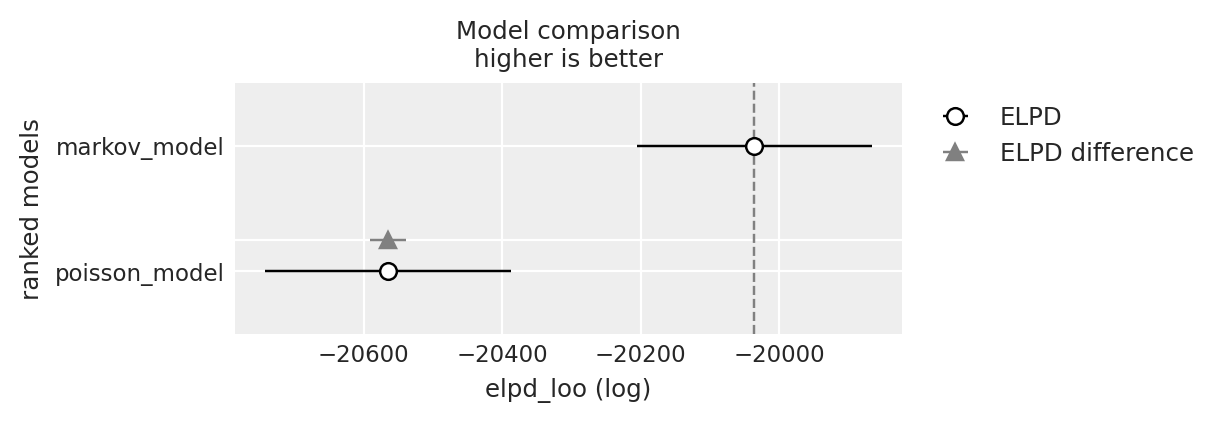

In [27]:
_ = az.plot_compare(df_comp_loo, insample_dev=False)

La differenza tra le stime dell'ELPD dei due modelli indica chiaramente che il modello che assume una dipendenza temporale tra le prove, qui modellizzata nei termini di un semplice processo di Markov di primo grado, è più adatto per i dati presenti che un modello di Poisson che assume che le prove siano tra loro indipendenti.

Una volta stabilito che le prove mostrano una dipendenza temporale, si tratta di capire se la prestazione post-errore sia migliore o peggiore rispetto alla prestazione post-corretta.

Il modello di Markov di primo ordine assume che la probabilità di commettere un errore in una prova dipenda dall'esito della prova precedente. Qui abbiamo due parametri principali:

   - `p_error_given_error`: La probabilità di commettere un errore dato che l'ultima prova è stata un errore.
   - `p_error_given_correct`: La probabilità di commettere un errore dato che l'ultima prova è stata corretta.

Dai dati ottenuti:

- `p_error_given_error` = 0.18: Significa che, se un atleta ha commesso un errore nella prova precedente, la probabilità di commettere un altro errore nella prova successiva è del 18%.
- `p_error_given_correct` = 0.08: Significa che, se un atleta ha eseguito correttamente la prova precedente, la probabilità di commettere un errore nella prova successiva è dell'8%.

Questa differenza tra `p_error_given_error` e `p_error_given_correct` suggerisce che gli atleti hanno una probabilità maggiore di commettere un errore se hanno appena commesso un errore rispetto a quando hanno eseguito correttamente la prova precedente. Questo è un chiaro segnale che esiste una *dipendenza temporale* tra le prove, che il modello di Markov cattura meglio rispetto al modello di Poisson.

Dal riepilogo dei dati si ottiene:

- Proporzione di risposte corrette dopo un errore: 0.819.
- Proporzione di risposte corrette dopo una prova corretta: 0.916.

In [51]:
# Step 1: Ordinare per atleta, run, e n_gate per garantire un corretto lagging
canoeing_data = canoeing_data.sort_values(by=["athlete", "run", "n_gate"])

# Creare la colonna lagged_accuracy
canoeing_data["lagged_accuracy"] = canoeing_data.groupby(["athlete", "run"])[
    "accuracy"
    ].shift(1)

# Step 2: Riassumere la proporzione di prove corrette dopo una risposta corretta o un errore
# Rimuovere le righe dove lagged_accuracy è NaN (ad esempio, la prima prova di ogni run)
df_filtered = canoeing_data.dropna(subset=["lagged_accuracy"])

# Raggruppare per lagged_accuracy e calcolare le proporzioni
proportions = (
    df_filtered.groupby("lagged_accuracy")
    .agg(correct_trials=("accuracy", "sum"), total_trials=("accuracy", "size"))
    .reset_index()
)

proportions["proportion_correct"] = (
    proportions["correct_trials"] / proportions["total_trials"]
).round(3)

# Stampare il risultato
print(proportions)

   lagged_accuracy  correct_trials  total_trials  proportion_correct
0              0.0            4828          5898               0.819
1              1.0           54368         59338               0.916


Questa differenza indica chiaramente che la prestazione dell'atleta peggiora dopo aver commesso un errore: è infatti più probabile che l'atleta commetta un altro errore subito dopo.

In conclusione, l'accuratezza dell'atleta tende a diminuire dopo un errore. Questo è meglio rappresentato dal modello di Markov, che evidenzia una probabilità maggiore di commettere un errore dopo un errore precedente rispetto a dopo una prova corretta. Al contrario, il modello di Poisson, che presuppone l'indipendenza tra le prove, non riesce a catturare adeguatamente questa dinamica, risultando quindi meno adatto per descrivere i tuoi dati.

Inoltre, l'intervallo di credibilità al 94% dei parametri `p_error_given_error` e `p_error_given_correct` non si sovrappone, il che supporta l'idea che queste due condizioni siano credibilmente diverse.

## Riflessioni Conclusive

Questo esercizio ci ha permesso di introdurre i modelli dinamici attraverso l'utilizzo di un processo di Markov di primo ordine per confrontare due teorie psicologiche che descrivono la prestazione post-errore: le teorie funzionali (@botvinick2001conflict), che prevedono un miglioramento della prestazione dopo un errore, e le teorie non funzionali (@notebaert2009post), che suggeriscono un peggioramento della prestazione in seguito a un errore.

Abbiamo utilizzato dati relativi alle prestazioni di atleti in eventi sportivi ufficiali per mettere alla prova queste teorie. Questi dati sono particolarmente interessanti rispetto a quelli raccolti in ambienti di laboratorio, poiché riflettono il comportamento reale degli individui in situazioni in cui gli errori hanno conseguenze significative.

In questo tutorial, abbiamo inizialmente considerato l'ipotesi che non vi fosse dipendenza temporale nelle prestazioni degli atleti, assumendo che gli errori fossero indipendenti nella sequenza delle prove. Questa ipotesi, che contrasta con entrambe le teorie funzionali e non funzionali, è stata implementata nel modello di Poisson, il quale presuppone l'indipendenza tra le prove.

Confrontando i modelli tramite la differenza nell'ELPD (Expected Log Predictive Density), abbiamo dimostrato che il modello semplice di Poisson può essere respinto e che i dati sono descritti in modo molto più accurato da un modello che assume una dipendenza temporale nelle prestazioni degli atleti. Il modello che incorpora questa ipotesi è un processo di Markov di primo ordine, che tiene conto dell'influenza della prova precedente sulla performance successiva.

Per confrontare le teorie funzionali e non funzionali post-errore, è stato fondamentale determinare la direzione della differenza nella prestazione post-errore: questa differenza indica un miglioramento o un peggioramento delle prestazioni?

Le statistiche descrittive hanno mostrato un peggioramento della prestazione post-errore. L'inferenza bayesiana, calcolando l'intervallo di credibilità al 94% per i parametri `p_error_given_error` e `p_error_given_correct`, ha confermato che questa differenza è credibile.

Possiamo quindi concludere che i dati relativi agli atleti nelle competizioni di alto livello di canoa slalom supportano le teorie non funzionali post-errore.

È importante, tuttavia, considerare alcune limitazioni di questa analisi.

Innanzitutto, il modello di Markov di primo ordine che abbiamo utilizzato non tiene conto del clustering delle prove, cioè del fatto che i dati provengono da atleti diversi. Ogni atleta ha caratteristiche uniche, e le prove all'interno della sequenza di un singolo atleta sono più simili tra loro rispetto a quelle di atleti diversi. Per semplicità, questo aspetto dei dati non è stato modellizzato. Un'analisi più approfondita richiederebbe l'uso di un modello gerarchico bayesiano, che, sebbene non necessario per gli scopi di questo tutorial, sarebbe più appropriato per un'analisi completa.

Inoltre, i dati presentano una questione più complessa. Abbiamo utilizzato questi dati per testare modelli psicologici che assumono che l'elaborazione delle informazioni e il comportamento restino coerenti dopo una prova corretta o un errore nella prova precedente. Tuttavia, questa assunzione potrebbe non essere valida nel contesto del canoa slalom. Se un atleta commette un errore, ciò potrebbe influenzare la posizione della canoa, rendendo più difficile o più facile superare la porta successiva. Questo potrebbe aumentare la probabilità di commettere un ulteriore errore o, in alcuni casi, ridurla. Per esplorare ulteriormente questo aspetto, sarebbe necessario analizzare i video delle prove, ma tale indagine va oltre gli obiettivi di questo tutorial.

Infine, non abbiamo analizzato schemi più complessi, come un peggioramento iniziale seguito da un successivo miglioramento, che potrebbero sostenere modelli integrativi come quello proposto da @danielmeier2011post.

In conclusione, nonostante le potenziali limitazioni di questo studio, i dati raccolti offrono un supporto maggiore alle teorie non funzionali rispetto a quelle funzionali della performance post-errore, specialmente quando si considerano dati reali sulle prestazioni di atleti di alto livello. Inoltre, indicano chiaramente che, almeno nel contesto esaminato, esiste una marcata dipendenza temporale tra le prove di una competizione atletica di alto livello.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Sat Jul 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

pingouin  : 0.5.4
logging   : 0.5.1.2
numpy     : 1.26.4
arviz     : 0.18.0
cmdstanpy : 1.2.3
matplotlib: 3.8.4
pandas    : 2.2.2
scipy     : 1.13.1

Watermark: 2.4.3

